In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.train import train_model, train_cellfate
from src.evaluation.evaluate import Evaluation
from src.training.loss_functions import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras.layers import Lambda, Input, GaussianNoise,concatenate, Dense, Dropout, Conv2D, Add, UpSampling2D, Dot, Conv2DTranspose, Activation, Reshape, InputSpec, LeakyReLU, Flatten, BatchNormalization, SpectralNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras import activations, initializers, regularizers, constraints
from tensorflow.python.keras.utils import conv_utils
from keras.layers import Dense, Conv1D, Conv2D, Conv3D, Conv2DTranspose, Embedding
import tensorflow as tf
from keras.models import load_model
from keras.applications import VGG19, VGG16
from keras.activations import swish
from keras.initializers import glorot_uniform, glorot_normal, GlorotUniform
from keras.constraints import max_norm, UnitNorm
from ipywidgets import interact, IntSlider
import tifffile as tiff
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [3]:
x_train = np.load('../data/stretched_x_train.npy')
y_train = np.load('../data/train_labels.npy')
x_test = np.load('../data/stretched_x_test.npy')
y_test = np.load('../data/test_labels.npy')

# Full cell fate

In [3]:
def evaluate_model(encoder, decoder, classifier, x_train, y_train, x_test, y_test, full_evaluation=False, output_dir="./results/evaluation"):
    """Evaluate the trained model."""
    evaluator = Evaluation(output_dir)
    
    print("HERE")
    z_imgs, _ = encoder.predict(x_train)
    recon_imgs = decoder.predict(z_imgs)
    #print(recon_imgs)
 
    evaluator.reconstruction_images(x_train, recon_imgs[:,:,:,0])
    
    if full_evaluation: 
        # Predict labels and plot confusion matrix
        test_latent_space, _ = encoder.predict(x_test)
        y_pred = classifier.predict(test_latent_space) 
        evaluator.plot_confusion_matrix(y_test, y_pred, num_classes=2)
        
        # Visualize latent space
        evaluator.visualize_latent_space(z_imgs, y_train)

        # Covariance matrix
        cov_matrix = cov_loss_terms(z_imgs)[0]
        evaluator.plot_cov_matrix(cov_matrix)

        # KL divergence
        print("KL Divergences in each dimension: ", evaluator.calculate_kl_divergence(z_imgs))


Training with batch size: 30, epochs: 10, learning rate: 0.001, seed: 69, latent dim: 20


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1/10: Reconstruction loss: 0.0810, Adversarial loss: 0.0399
Epoch 2/10: Reconstruction loss: 0.0424, Adversarial loss: 0.0393
Epoch 3/10: Reconstruction loss: 0.0356, Adversarial loss: 0.0393
Epoch 4/10: Reconstruction loss: 0.0335, Adversarial loss: 0.0395
Epoch 5/10: Reconstruction loss: 0.0324, Adversarial loss: 0.0401
Epoch 6/10: Reconstruction loss: 0.0316, Adversarial loss: 0.0400
Epoch 7/10: Reconstruction loss: 0.0316, Adversarial loss: 0.0402
Epoch 8/10: Reconstruction loss: 0.0312, Adversarial loss: 0.0410
Epoch 9/10: Reconstruction loss: 0.0311, Adversarial loss: 0.0400
Epoch 10/10: Reconstruction loss: 0.0299, Adversarial loss: 0.0404
Saving loss plot...
Saving model weights...
Encoder weights saved to ./results/models/encoder.weights.h5
Decoder weights saved to ./results/models/decoder.weights.h5
Discriminator weights saved to ./results/models/discriminator.weights.h5
Training with batch size: 30, epochs: 50, learning rate: 0.0001, seed: 69, latent dim: 20
Epoch 1/50

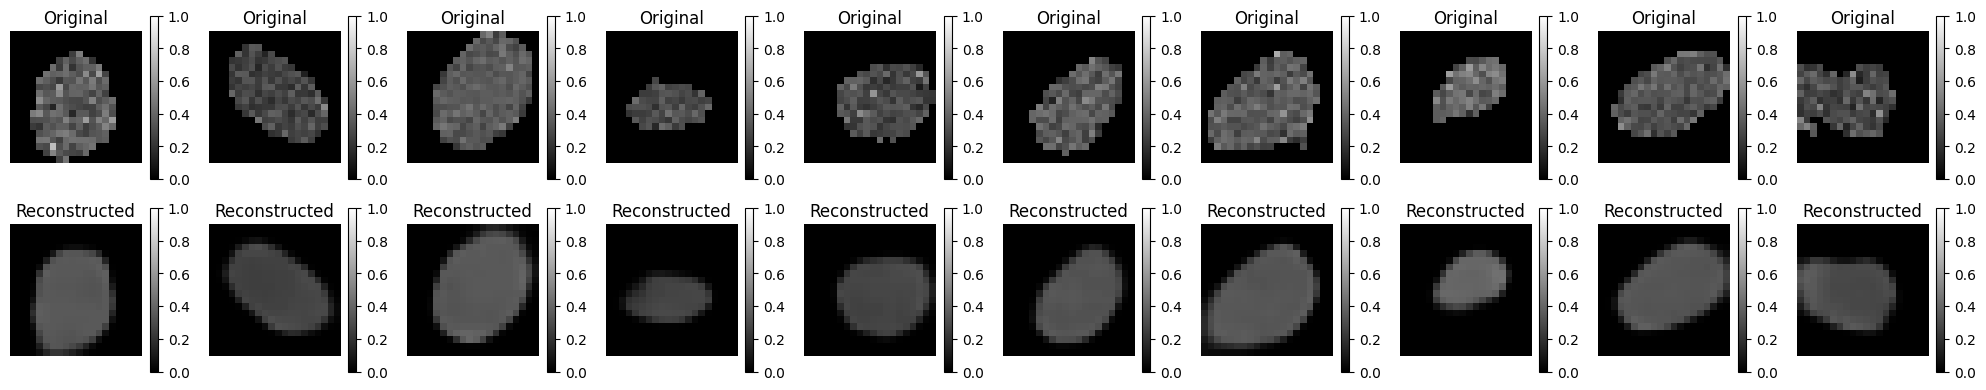

Reconstruction images saved to ./results/evaluation/reconstruction_images.png
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


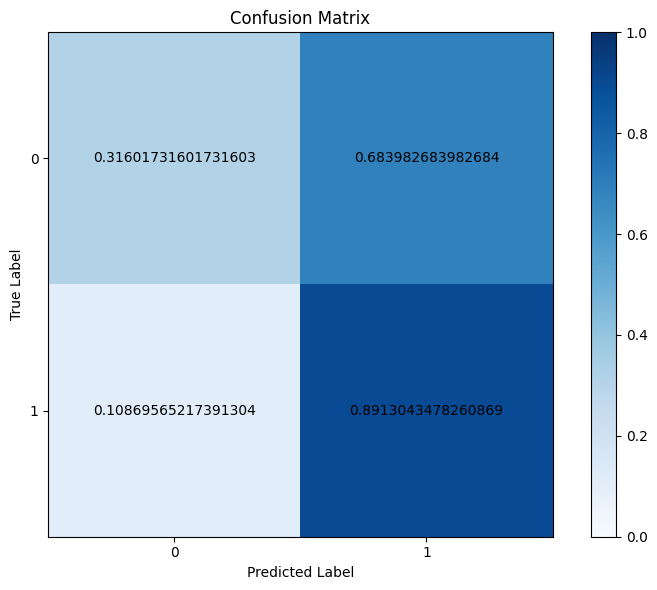

Confusion matrix saved to ./results/evaluation/confusion_matrix.png
Top correlated features: 7, 8


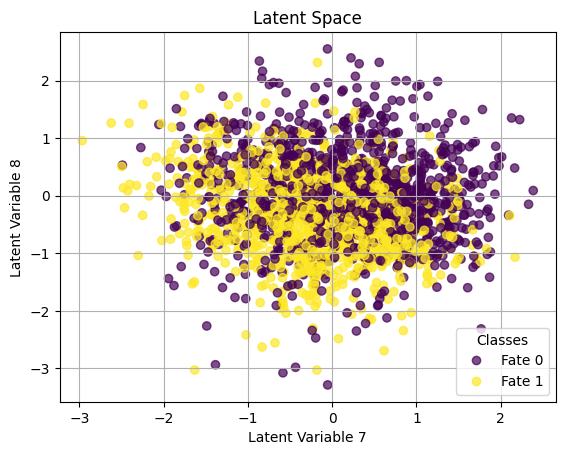

Latent space visualization saved to ./results/evaluation/latent_space.png


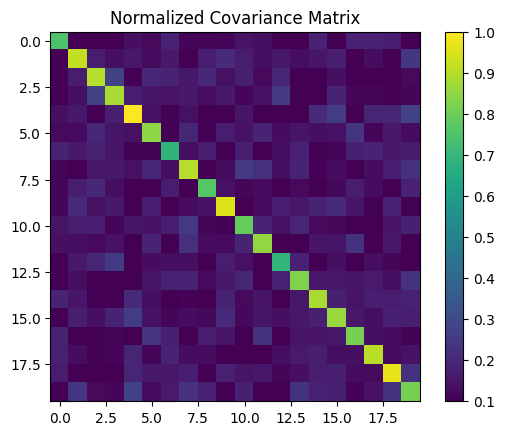

Covariance matrix saved to ./results/evaluation/cov_matrix.png
KL Divergences in each dimension:  [0.1544869377341804, 0.031199721355600594, 0.04621494598756408, 0.04394145046362631, 0.058798619491225834, 0.044191473630887546, 0.0982345837192194, 0.03412463877530878, 0.08633473366247436, 0.07715611860171988, 0.07864349715098169, 0.04448128584469996, 0.09054715454636446, 0.06928762062044011, 0.050444975762555626, 0.11044833923531244, 0.07969525428775943, 0.09324214234954128, 0.05674017556471276, 0.10353106577588418]


In [4]:
config = {
    'batch_size': 30,
    'epochs': 10,
    'learning_rate': 0.001,
    'seed': 69,
    'latent_dim': 20,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

# first train the autoencoder
autoencoder_results = train_model(config, x_train)
encoder = autoencoder_results['encoder']
decoder = autoencoder_results['decoder']
discriminator = autoencoder_results['discriminator']

config = {
        'batch_size': 30,
        'epochs': 50,
        'learning_rate': 0.0001,
        'seed': 69,
        'latent_dim': 20,
        'GaussianNoise_std': 0.003,
        'lambda_recon': 5, 
        'lambda_adv': 0.05,
        'lambda_clf': 0.05,
        'lambda_cov': 0.1,
    }

# Train the full model
full_model_results = train_cellfate(config, encoder, decoder, discriminator, x_train, y_train, x_test, y_test)
final_encoder = full_model_results['encoder']
final_decoder = full_model_results['decoder']
classifier = full_model_results['classifier']

# Evaluate the model
evaluate_model(final_encoder, final_decoder, classifier, x_train, y_train, x_test, y_test, full_evaluation=True)

# then train the cellfate model
#results = train_cellfate(config, results_autoencoder['encoder'], results_autoencoder['decoder'], results_autoencoder['discriminator'], x_train, y_train, x_test, y_test)

## Checking why it is overfitting

In [5]:
test_latent_space, _ = final_encoder.predict(x_test)
test_reconstructed = final_decoder.predict(test_latent_space)
y_pred = classifier.predict(test_latent_space)

y_pred_classes = np.argmax(y_pred, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step


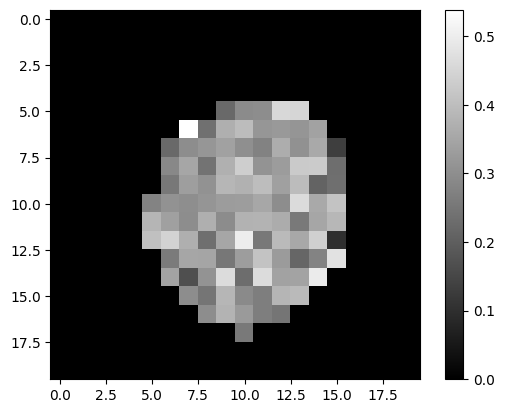

In [21]:
plt.imshow(x_test[19,:,:], cmap='gray')
plt.colorbar()

In [ ]:


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

num_classes = len(np.unique(y_train))
# Build a new model for your task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to flatten feature maps
x = Dense(512, activation='relu')(x)  
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)
# Final model
clf_model = Model(inputs=base_model.input, outputs=outputs)

# Freeze VGG19 layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

tf.keras.utils.set_random_seed(812)

clf_model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, clipvalue=0.5), metrics=["accuracy"])

clf_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.5093 - loss: 0.7432 - val_accuracy: 0.6377 - val_loss: 0.6469
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5950 - loss: 0.6773 - val_accuracy: 0.6884 - val_loss: 0.6123
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6154 - loss: 0.6649 - val_accuracy: 0.6522 - val_loss: 0.6361
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6389 - loss: 0.6513 - val_accuracy: 0.6449 - val_loss: 0.6264
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6405 - loss: 0.6390 - val_accuracy: 0.6449 - val_loss: 0.6193
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6525 - loss: 0.6235 - val_accuracy: 0.6377 - val_loss: 0.6249
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6451 - loss: 0.6203 - val_accuracy: 0.6304 - val_loss: 0.6263
Epoch 8/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6625 - loss: 0.6099 - val_accuracy: 0.

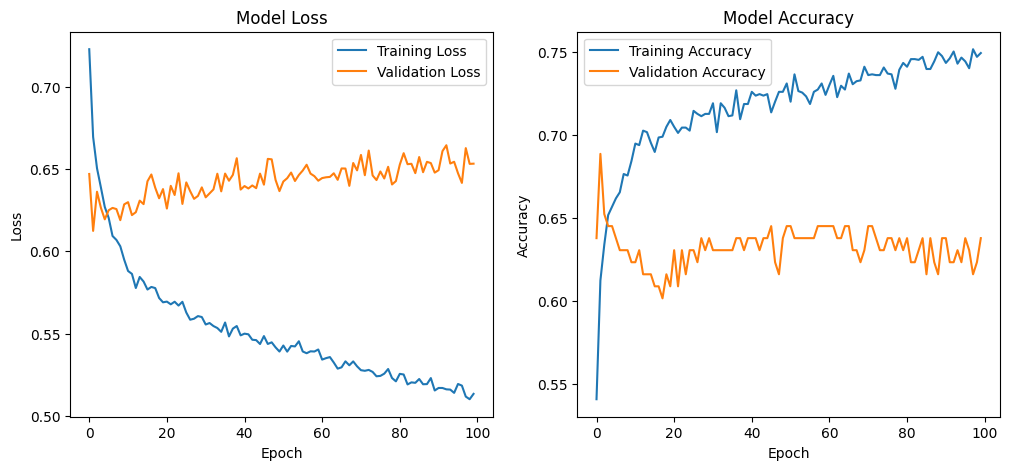

In [5]:
def process_for_vgg(image): # the input is (20, 20)
    # Pad to make it the minimum size for VGG (32, 32, 3)
    image = np.expand_dims(image, axis=-1)
    padded_x_train = np.pad(image, ((0, 0), (6, 6), (6, 6), (0, 0)), mode='constant')
    padded_x_train = np.concatenate((padded_x_train, padded_x_train), axis=-1)
    padded_x_train = np.concatenate((padded_x_train, padded_x_train[:,:,:,0:1]), axis=-1)
    return padded_x_train

x_val, x_test_, y_val, y_test_ = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

history = clf_model.fit(process_for_vgg(x_train), y_train, batch_size=32, epochs=100, validation_data=(process_for_vgg(x_val), y_val))

plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[[0.62162162 0.37837838]
 [0.32142857 0.67857143]]


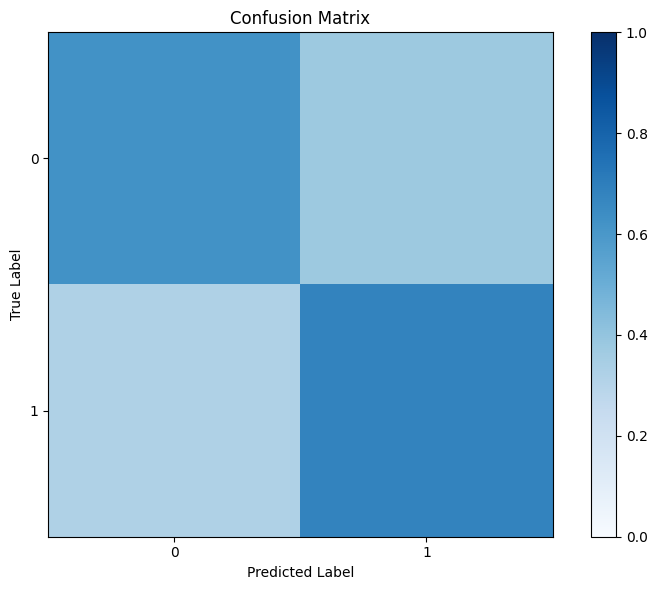

In [6]:
num_classes = len(np.unique(y_train))
y_pred = clf_model.predict(process_for_vgg(x_test_))
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Getting pretrained full model without classifier

In [4]:
from src.models import Encoder, Decoder, Discriminator, mlp_classifier

config = {
    'batch_size': 30,
    'epochs': 100,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 10,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/models/encoder.weights.h5")
decoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/models/decoder.weights.h5")
discriminator.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/models/discriminator.weights.h5")

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [5]:
tf.keras.utils.set_random_seed(config['seed'])

classifier = mlp_classifier(latent_dim=config['latent_dim'])

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test)[0], y_test, test_size=0.5, random_state=42)

history = classifier.fit(encoder.predict(x_train)[0], y_train, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val, y_val)) # 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 914 (3.57 KB)

 Trainable params: 914 (3.57 KB)

 Non-trainable params: 0 (0.00 B)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5264 - loss: 0.7609 - val_accuracy: 0.5072 - val_loss: 0.7231
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.5890 - loss: 0.6785 - val_accuracy: 0.4783 - val_loss: 0.7110
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6015 - loss: 0.6616 - val_accuracy: 0.5290 - val_loss: 0.6924
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.6298 - loss: 0.6343 - val_accuracy: 0.5507 - val_loss: 0.6899
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6493 - loss: 0.6322 - val_accuracy: 0.5797 - val_loss: 0.6535
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.6479 - loss: 0.6356 - val_accuracy: 0.5797 - val_loss: 0.6489
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6525 - loss: 0.6263 - val_accuracy: 0.5870 - val_loss: 0.6457
Epoch 8/100
73/73 ━━━━

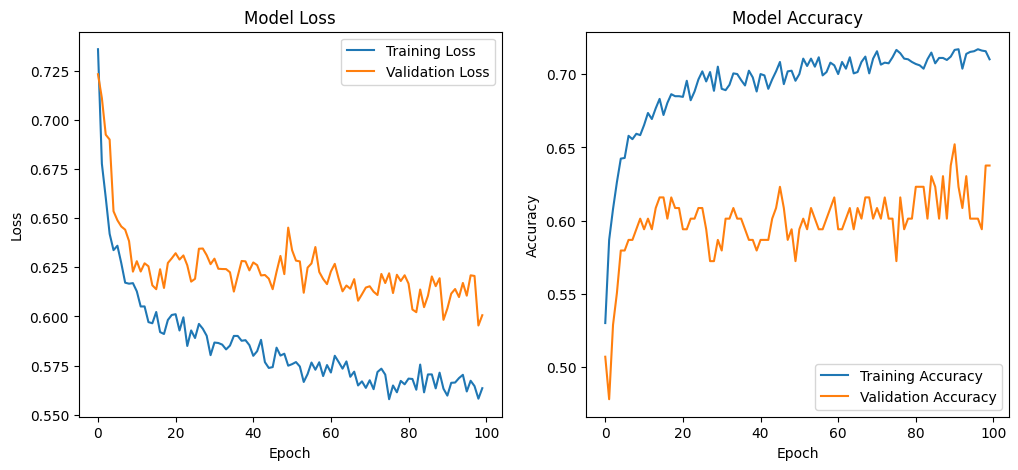

In [6]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[0.56756757 0.43243243]
 [0.21428571 0.78571429]]


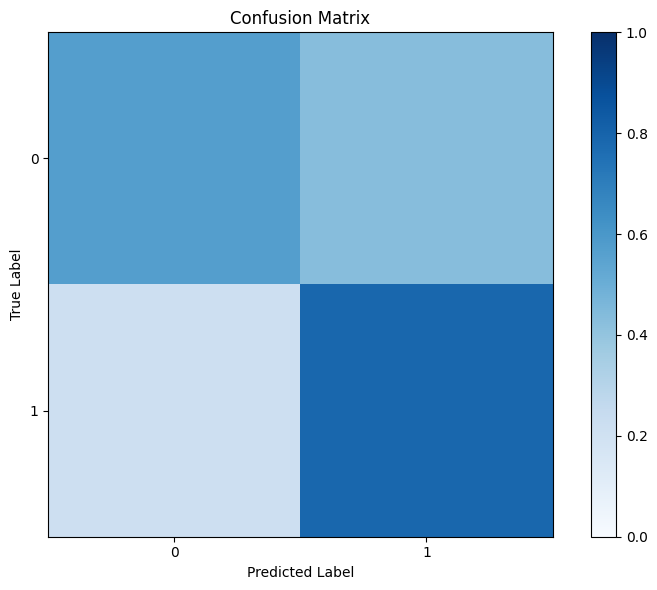

In [7]:
num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [25]:
y_test_

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0])

In [8]:
y_pred_classes

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0])

In [7]:
z_imgs, z_scores = results['encoder'].predict(x_train)
recon = results['decoder'].predict(z_imgs)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


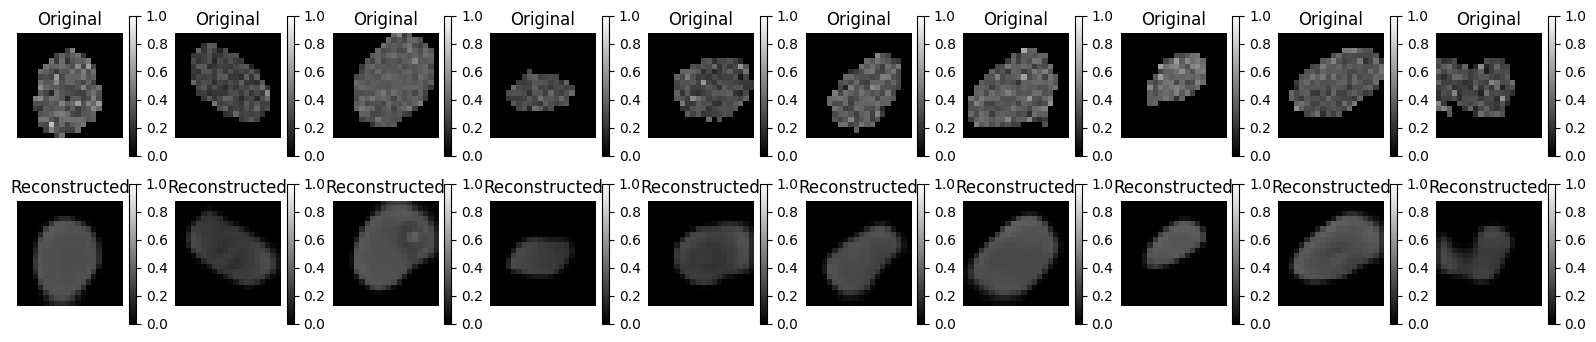

In [6]:
n = 10  # Number of images to display

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i][:, :], cmap="gray", vmin=0.0, vmax=x_train.max())  # Display channel 1 image_batch[i].reshape(20, 20, 2)
    plt.title("Original")
    plt.axis("off")
    plt.colorbar()

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(recon[i][:, :, 0], cmap="gray", vmin=0.0, vmax=x_train.max())  # Display channel 1
    plt.title("Reconstructed")
    plt.axis("off")
    plt.colorbar()
plt.show()

In [11]:
z_imgs.shape

(2184, 20)

In [12]:
kl_divergences = calculate_kl_divergence(z_imgs)

# Print the KL divergences for each dimension
for i, kl_div in enumerate(kl_divergences):
    print(f"Latent Dimension {i + 1}: KL Divergence = {kl_div:.4f}")

Latent Dimension 1: KL Divergence = 0.1044
Latent Dimension 2: KL Divergence = 0.3005
Latent Dimension 3: KL Divergence = 0.0306
Latent Dimension 4: KL Divergence = 0.1166
Latent Dimension 5: KL Divergence = 0.1618
Latent Dimension 6: KL Divergence = 0.1331
Latent Dimension 7: KL Divergence = 0.0410
Latent Dimension 8: KL Divergence = 0.1227
Latent Dimension 9: KL Divergence = 0.0473
Latent Dimension 10: KL Divergence = 0.0440
Latent Dimension 11: KL Divergence = 0.0722
Latent Dimension 12: KL Divergence = 0.0662
Latent Dimension 13: KL Divergence = 0.0529
Latent Dimension 14: KL Divergence = 0.0412
Latent Dimension 15: KL Divergence = 0.0685
Latent Dimension 16: KL Divergence = 0.2151
Latent Dimension 17: KL Divergence = 0.0323
Latent Dimension 18: KL Divergence = 0.0570
Latent Dimension 19: KL Divergence = 0.0299
Latent Dimension 20: KL Divergence = 0.0426
